<a href="https://colab.research.google.com/github/StephMcCallum/MSE563-SM/blob/main/Project_1_SM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Metropolis MC Sampling Algorithm for Lennard-Jonesium

In [90]:
import numpy
import random
k_B = 1.0
directions = [numpy.array((1,0,0)),numpy.array((0,-1,0)),numpy.array((-1,0,0)),numpy.array((0,1,0)),numpy.array((0,0,1)),numpy.array((0,0,-1))]
def pbc(site,L): #The convention here is to have positive lattice indices
  for i,s in enumerate(site):
    if s >= L:
      site[i] = s - L
    elif s < 0:
      site[i] = s + L
  return site

class box():
  def __init__(self,N,L,T,ideal=False):
    self.L = L
    self.N = N
    self.density = self.N/(self.L**3)
    self.epsilon = -1
    self.kT = T
    self.ideal = ideal
    self.particles = []
    for i in range(self.N):
      self.particles.append(particle())
      while True:
        rands = self.random_site()
        if not self.occupied(rands):
          self.particles[-1].location = rands
          break
    self.E,self.virial = self.energy()
    self.P = self.pressure()

  def occupied(self,site):
    for p in self.particles:
      if numpy.array_equal(p.location,site):
        return True
    return False

  def random_site(self):
    return numpy.array((random.uniform(0,self.L),random.uniform(0,self.L),random.uniform(0,self.L)))

  def distance(self,site1,site2,epsilon=1.0,sigma=1.0):
    delta = site1 - site2
    r = numpy.linalg.norm(delta)
    if r > (self.L/2):
      delta -= numpy.round(delta/self.L) * self.L #considering PBC
      r = numpy.linalg.norm(delta)
    f_magnitude = 24 * epsilon * (2 * (sigma / r)**12 - (sigma / r)**6) / r
    force = f_magnitude*delta/r #force vector
    return r,force,delta

  def lennard_jones_potential(self,r, epsilon=1.0, sigma=1.0):
    tail_correction = (8/3)*numpy.pi*self.density*((1/3)*(1/(self.L/2))**9 - (1/(self.L/2))**3)
    if r == 0:
      return numpy.inf
    if r > self.L/2: #r-cut
      return 0
    potential = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6) + tail_correction
    return potential

  def energy(self):
    energy = 0
    virial_sum = 0
    if self.ideal == True:
      return energy, virial_sum
    for p in self.particles:
      for n in self.particles:
        if self.occupied(n.location) and not numpy.array_equal(n.location,p.location):
          r,force,delta = self.distance(p.location,n.location)
          energy += self.lennard_jones_potential(r)
          virial_sum += numpy.dot(force, delta)
    return energy/2, virial_sum

  def pressure(self):
    density = self.density
    P_ideal = (density*k_B*self.kT)/(self.L**3)
    P_correction = (16/3) *numpy.pi* (self.density**2)*((2/3)*(1/(self.L/2))**9 - (1/(self.L/2))**3)
    pressure = P_ideal + (self.virial/(3*(self.L**3)))
    return pressure


  def __repr__(self):
    m = numpy.zeros((self.L,self.L,self.L))
    for p in self.particles:
      m[tuple(p.location)] = 1
    return str(m)

class particle():
  def __init__(self):
    self.location = numpy.array((-1.0,-1.0,-1.0))

class simulation():
  def __init__(self,N,L,T,steps,ideal_gas=False,seed=2):
    numpy.random.seed(seed)
    self.box = box(N,L,T,ideal_gas)
    self.accepted = 0
    self.rejected = 0
    self.T = T
    self.energies = numpy.zeros(steps)
    for i in range(steps):
      self.trial_move()
      self.energies[i] = self.box.E/N
    self.C_v = self.heat_capacity()
    #self.plot = self.plot(self.box.particles,self.box.L)


  def heat_capacity(self):
    mean_energy = numpy.mean(self.energies)
    mean_energy_squared = numpy.mean(numpy.array(self.energies)**2)
    k_B = 1.0
    return (mean_energy_squared - mean_energy**2) / (self.T**2 * k_B)

  def trial_move(self):
    p = numpy.random.choice(self.box.particles)
    old = p.location
    oldE = self.box.E
    trial = self.box.random_site()
    if not self.box.occupied(trial):
      p.location = trial
      E = self.box.energy()[0]
      dE = E - oldE
      if numpy.random.rand() < numpy.exp(-dE/self.box.kT):
        self.box.E = E
        self.accepted += 1
        return
    p.location = old #need to reject moves that are overlaps
    self.box.E = oldE
    self.rejected += 1

  def plot(self, particles, L):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    for p in particles:
      ax.scatter(p.location[0], p.location[1], p.location[2], c='blue', marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    #plt.title(title)
    #plt.show()



In [34]:
k_B = 1.0
ideal_gas_C_v = 3/2*k_B

#Analysis
##Characterize performance:
## Extremes of state

<ipython-input-47-6ff45b35410f>:121: RuntimeWarning: overflow encountered in exp
  if numpy.random.rand() < numpy.exp(-dE/self.box.kT):


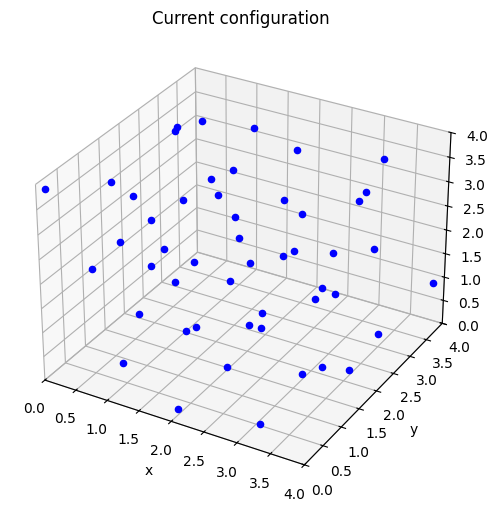

Acceptance rate: 0.134


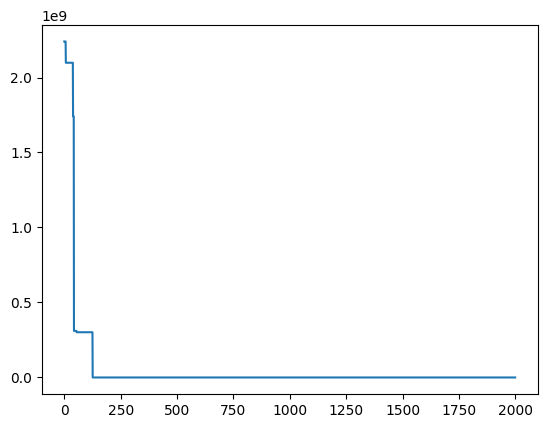

In [56]:
#Extreme: high density, low temperature
import matplotlib.pyplot as plt
s = simulation(N=50,L=4,T=0.05,steps=2000,seed = 2) #density of 0.8
plt.plot(s.energies)
print("Acceptance rate:", s.accepted/500)

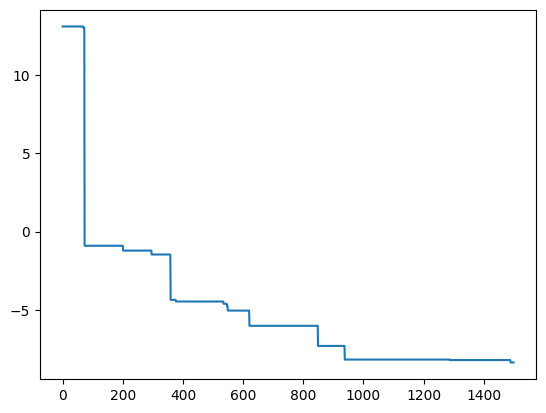

In [60]:
plt.plot(s.energies[500:])

In [69]:
print("corrected acceptance rate:",0.134*500/2000)

corrected acceptance rate: 0.0335


The dense system at low temperature above takes over 2000 steps to equillibrate. The high initial energies are misleading in the first graph. The acceptance rate it low, 3%.

<ipython-input-67-fccfe805471c>:121: RuntimeWarning: overflow encountered in exp
  if numpy.random.rand() < numpy.exp(-dE/self.box.kT):


Acceptance rate: 0.144


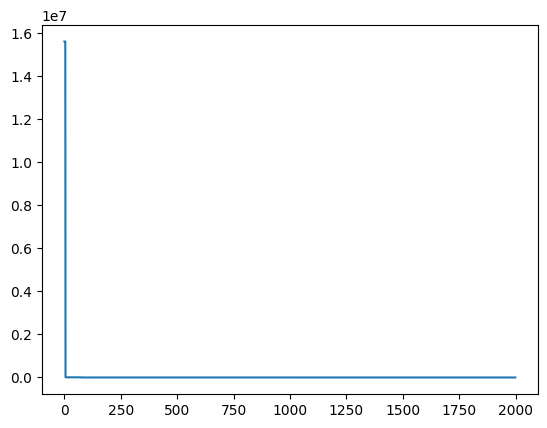

In [70]:
#Extreme: not as high density, not as low temperature
import matplotlib.pyplot as plt
s = simulation(N=40,L=4,T=0.1,steps=2000,seed = 2) #density of 0.8
plt.plot(s.energies)
print("Acceptance rate:", s.accepted/500)

Acceptance rate: 0.036


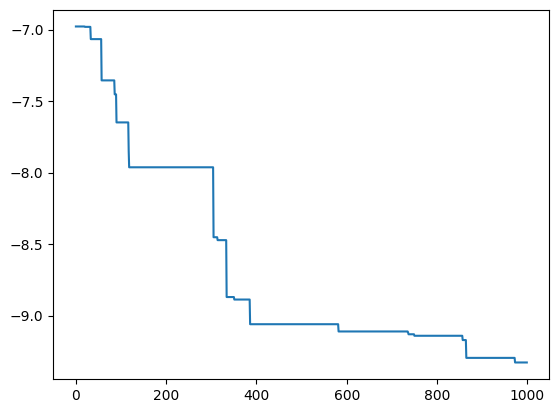

In [72]:
print("Acceptance rate:", s.accepted/2000)
plt.plot(s.energies[1000:])

<ipython-input-67-fccfe805471c>:121: RuntimeWarning: overflow encountered in exp
  if numpy.random.rand() < numpy.exp(-dE/self.box.kT):


Acceptance rate: 0.154


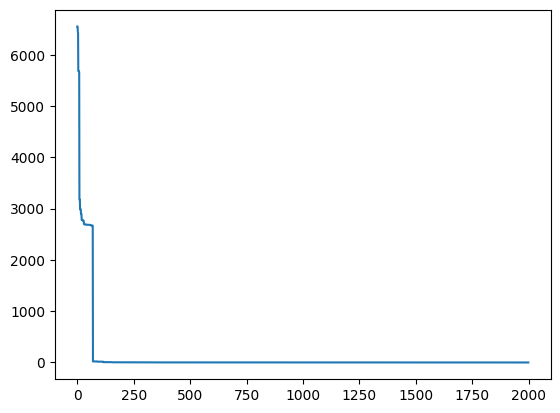

In [73]:
#Extreme: not as high density, not as low temperature
import matplotlib.pyplot as plt
s = simulation(N=32,L=4,T=0.5,steps=2000,seed = 2) #density of 0.5
plt.plot(s.energies)
print("Acceptance rate:", s.accepted/500)

Acceptance rate: 0.0385


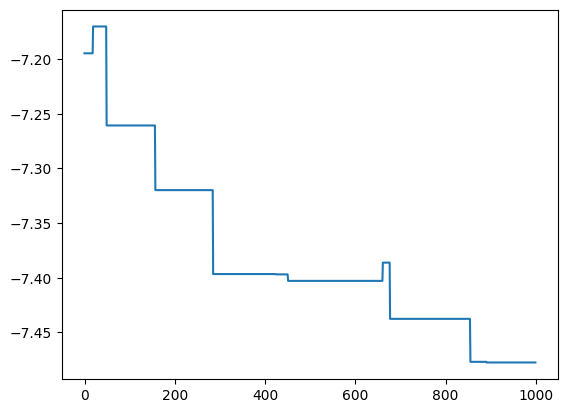

In [74]:
print("Acceptance rate:", s.accepted/2000)
plt.plot(s.energies[1000:])

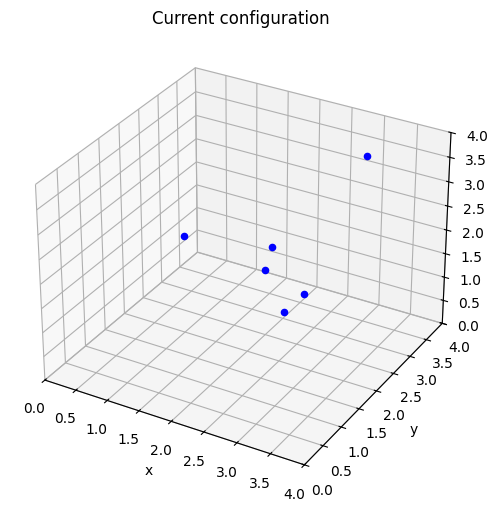

66.1164878008569 38.722232722308824 0.269


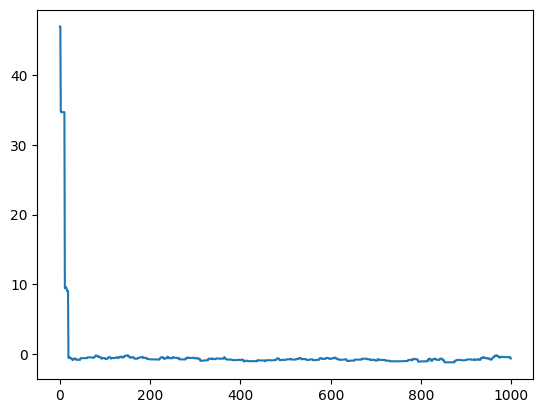

In [36]:
import matplotlib.pyplot as plt
s = simulation(N=6,L=4,T=0.5,steps=1000, seed = 2)
plt.plot(s.energies)
print(s.C_v,s.box.P,s.accepted/1000)

## Too small, too big

In [77]:
import time
for N in [2,5,10,15,20]:
  t1 = time.perf_counter()
  s = simulation(N=N,L=10,T=1.0,steps=200, seed = 2)
  t2 = time.perf_counter()
  print("\nN=",N,"seconds/100steps =", t2-t1)
  print("acceptance rate:",s.accepted/200)


N= 2 seconds/100steps = 0.036011864998727106
acceptance rate: 0.985

N= 5 seconds/100steps = 0.29892117099916504
acceptance rate: 0.935

N= 10 seconds/100steps = 1.3176399919993855
acceptance rate: 0.885

N= 15 seconds/100steps = 2.494499132999408
acceptance rate: 0.785

N= 20 seconds/100steps = 4.898289689999729
acceptance rate: 0.805


The acceptance rate is high for small N. This may also be an artifact of the algorithm starting at a high energy.

In [13]:
import time
for N in [5,10,50,100,200,500]:
  t1 = time.perf_counter()
  s = simulation(N=N,L=100,T=0.5,steps=100, seed = 2)
  t2 = time.perf_counter()
  print("\nN=",N,"seconds/100steps =", t2-t1)
  if t2-t1 > 30:
    print("Taking a minute for 200 steps. TOO SLOW")
    break



N= 5 seconds/100steps = 0.11470363499995528

N= 10 seconds/100steps = 0.5911562629999025

N= 50 seconds/100steps = 32.91948636900008
Taking a minute for 200 steps. TOO SLOW


Looking at the computation time, N > 50 is too big of a system.

#Comparison with an Ideal Gas

specific heat: 0.0678814715103312 acceptance 0.596


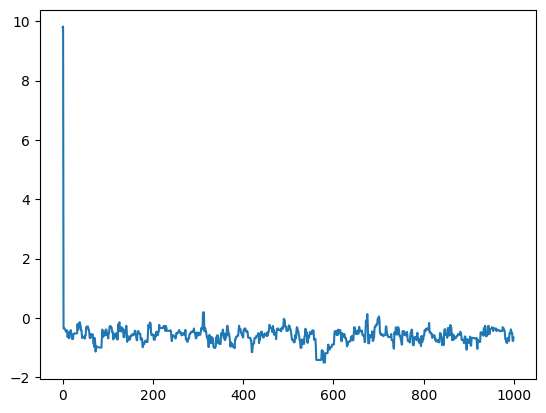

In [86]:
import matplotlib.pyplot as plt
s = simulation(N=6,L=4,T=2.0,steps=1000,seed = 10)
plt.plot(s.energies)
print("specific heat:",s.C_v,"acceptance",s.accepted/1000)

0.0 1.0


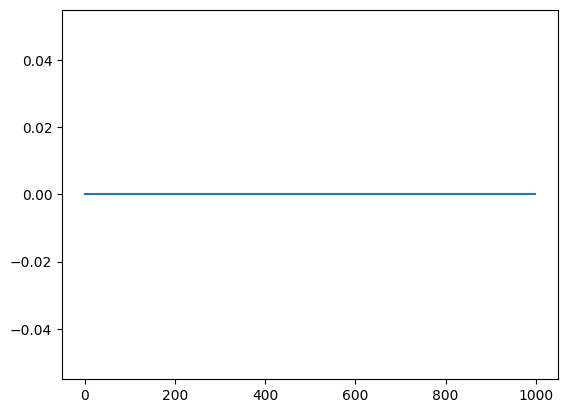

In [91]:
import matplotlib.pyplot as plt
s = simulation(N=6,L=4,T=2.0,steps=1000,ideal_gas=True,seed = 2)
plt.plot(s.energies)
print(s.C_v,s.accepted/1000)

<ipython-input-67-fccfe805471c>:121: RuntimeWarning: overflow encountered in exp
  if numpy.random.rand() < numpy.exp(-dE/self.box.kT):


Text(0, 0.5, 'pressure')

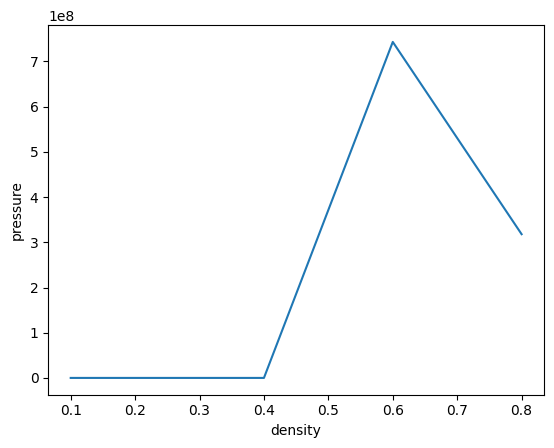

In [68]:
import matplotlib.pyplot as plt
energies = []
pressures = []
density =  [0.1,0.2,0.3,0.4,0.6,0.8]
L = 4
for p in density:
  s = simulation(N=int(numpy.round((L**3)*p)),L=L,T=2.0,steps=1000, seed = numpy.random.randint(100000))
  energies.append(s.energies)
  pressures.append(s.box.P)


plt.plot(density,pressures)
plt.xlabel("density")
plt.ylabel("pressure")

# Project Summary

For this project, I chose to implement a Lennard-Jonesium MC algorithm. The goals was to represent a 3D simulation box with off-lattice, interacting beads. I started the project with a working 2D Lattice MC algorithm and adapted this to a 3D system, changed the location of the particles to float variables, and implemented a Lennard-Jones potential energy function. I included an r_cut of the box length divided by 2 and a tail correction as suggested in Frenkel & Smit Chapter 3, Case Study 1. The MC simulation is of the canconical ensemble. To easily probe the thermodynamics, I saved important variables to the class so that they could easily be used in other functions.

While this code is running, the energy function is not fluctuating as expected. I'm also receiving an error, likely related, of an overflow from the exponential calculation with energy. One bug that I noticed, is that sometimes when I ran the same simulation, I would get different energy results. One run would start at a extremely high temperature and then drop with no fluctuations. Another would only fluctuate around one energy.

I implemented a function for heat capacity of this system. I tried comparing this to an ideal gas by calculating the heat capacity for my system at a low density and high temperature. I also included an option in my code for an ideal gas, where the simulation with accept all moves. I would expect to see that the ideal gas, or the system with no interactions, has a heat capacity that scales to 3/2(N)k_B. I did not find any conclusive results here.

I attempted to derive an equation of state using the virial theorem. I implemented this function to calculate pressure of the canonical ensemble. For this calculation, I also included a pressure correction term. Above, I attempted to graph density vs. pressure for multiple systems.

Reflecting on this project, I learned a lot about Python and implementing classes. I wrote a lot of functions in one class and with more time, I could likely move those to their own class or utility functions file. If I were to spend more time on this project, I would try to make the simulation more efficient so that I could investigate larger systems. I would also start the project earlier so that I could better ask for help.

As a bonus(a failed first attempt), I also tried to implement the Gay-Berne potential: https://github.com/StephMcCallum/MSE563-SM/blob/main/MC_Ellipsoid_attempt.ipynb.